In [1]:
# installation comes first

!pip install neo4j

In [2]:
from neo4j import GraphDatabase

In [3]:
class SocialNetworkApp:

    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self.driver.close()

    def register_user(self, user_id, name, age, location, interests):
        with self.driver.session() as session:
            session.write_transaction(self._create_user_node, user_id, name, age, location, interests)

    @staticmethod
    def _create_user_node(tx, user_id, name, age, location, interests):
        query = """
        CREATE (u:User {id: $user_id, name: $name, age: $age, location: $location, interests: $interests})
        """
        tx.run(query, user_id=user_id, name=name, age=age, location=location, interests=interests)

    def update_user_info(self, user_id, updated_info):
        with self.driver.session() as session:
            session.write_transaction(self._update_user_node, user_id, updated_info)

    @staticmethod
    def _update_user_node(tx, user_id, updated_info):
        set_clause = ", ".join([f"u.{key} = ${key}" for key in updated_info.keys()])
        query = f"""
        MATCH (u:User) WHERE u.id = $user_id
        SET {set_clause}
        """
        tx.run(query, user_id=user_id, **updated_info)

    def send_friend_request(self, sender_id, receiver_id):
        with self.driver.session() as session:
            session.write_transaction(self._create_friend_request, sender_id, receiver_id)

    @staticmethod
    def _create_friend_request(tx, sender_id, receiver_id):
        query = """
        MATCH (sender:User {id: $sender_id}), (receiver:User {id: $receiver_id})
        CREATE (sender)-[:OUTGOING_REQUEST]->(receiver)
        CREATE (receiver)-[:INCOMING_REQUEST]->(sender)
        """
        tx.run(query, sender_id=sender_id, receiver_id=receiver_id)

    def accept_friend_request(self, sender_id, receiver_id):
        with self.driver.session() as session:
            session.write_transaction(self._accept_friend_request, sender_id, receiver_id)

    @staticmethod
    def _accept_friend_request(tx, sender_id, receiver_id):
        query = """
        MATCH (sender:User {id: $sender_id})-[r:OUTGOING_REQUEST]->(receiver:User {id: $receiver_id}),
            (receiver)-[r2:INCOMING_REQUEST]->(sender)
        DELETE r, r2
        CREATE (sender)-[:FRIENDS_WITH]->(receiver),
            (receiver)-[:FRIENDS_WITH]->(sender)
        """
        tx.run(query, sender_id=sender_id, receiver_id=receiver_id)


    def reject_friend_request(self, sender_id, receiver_id):
        with self.driver.session() as session:
            session.write_transaction(self._reject_friend_request, sender_id, receiver_id)

    @staticmethod
    def _reject_friend_request(tx, sender_id, receiver_id):
        query = """
        MATCH (sender:User {id: $sender_id})-[r:OUTGOING_REQUEST]->(receiver:User {id: $receiver_id})
        DELETE r
        MATCH (receiver)-[r2:INCOMING_REQUEST]->(sender)
        DELETE r2
        """
        tx.run(query, sender_id=sender_id, receiver_id=receiver_id)

    def unfriend(self, user_id, friend_id):
        with self.driver.session() as session:
            session.write_transaction(self._unfriend_user, user_id, friend_id)

    @staticmethod
    def _unfriend_user(tx, user_id, friend_id):
        query = """
        MATCH (user:User {id: $user_id})-[r:FRIENDS_WITH]->(friend:User {id: $friend_id})
        DELETE r
        MATCH (friend)-[r2:FRIENDS_WITH]->(user)
        DELETE r2
        """
        tx.run(query, user_id=user_id, friend_id=friend_id)

    def create_post(self, user_id, content, timestamp):
        with self.driver.session() as session:
            session.write_transaction(self._create_post_node, user_id, content, timestamp)

    @staticmethod
    def _create_post_node(tx, user_id, content, timestamp):
        query = """
        MATCH (u:User {id: $user_id})
        CREATE (u)-[:POSTED]->(:Post {content: $content, timestamp: $timestamp})
        """
        tx.run(query, user_id=user_id, content=content, timestamp=timestamp)

    def like_post(self, user_id, post_id):
        with self.driver.session() as session:
            session.write_transaction(self._create_like_relationship, user_id, post_id)

    @staticmethod
    def _create_like_relationship(tx, user_id, post_id):
        query = """
        MATCH (u:User {id: $user_id}), (p:Post {id: $post_id})
        CREATE (u)-[:LIKES]->(p)
        """
        tx.run(query, user_id=user_id, post_id=post_id)

    def comment_on_post(self, user_id, post_id, comment_text):
        with self.driver.session() as session:
            session.write_transaction(self._create_comment_relationship, user_id, post_id, comment_text)

    @staticmethod
    def _create_comment_relationship(tx, user_id, post_id, comment_text):
        query = """
        MATCH (u:User {id: $user_id}), (p:Post {id: $post_id})
        CREATE (u)-[:COMMENTED_ON {text: $comment_text}]->(p)
        """
        tx.run(query, user_id=user_id, post_id=post_id, comment_text=comment_text)

    def join_group(self, user_id, group_id):
        with self.driver.session() as session:
            session.write_transaction(self._create_join_relationship, user_id, group_id)

    @staticmethod
    def _create_join_relationship(tx, user_id, group_id):
        query = """
        MATCH (u:User {id: $user_id}), (g:Group {id: $group_id})
        CREATE (u)-[:JOINED]->(g)
        """
        tx.run(query, user_id=user_id, group_id=group_id)

    def recommend_friends(self, user_id):
        with self.driver.session() as session:
            return session.read_transaction(self._find_friend_recommendations, user_id)

    @staticmethod
    def _find_friend_recommendations(tx, user_id):
        query = """
        MATCH (u:User {id: $user_id})-[:FRIENDS_WITH]->(friend)-[:FRIENDS_WITH]->(mutual)
        WHERE NOT (u)-[:FRIENDS_WITH]->(mutual) AND u <> mutual
        RETURN mutual
        """
        result = tx.run(query, user_id=user_id)
        return [record["mutual"] for record in result]

    def search_users(self, search_name):
        with self.driver.session() as session:
            return session.read_transaction(self._search_for_users, search_name)

    @staticmethod
    def _search_for_users(tx, search_name):
        query = """
        MATCH (u:User)
        WHERE u.name CONTAINS $search_name
        RETURN u
        """
        result = tx.run(query, search_name=search_name)
        return [record["u"] for record in result]

In [4]:
!pip install python-dotenv

In [5]:
# read from env file
import os
from dotenv import load_dotenv
load_dotenv()

True

In [6]:
# get the credentials from the environment file
uri = os.getenv("NEO_URI")
user = os.getenv("NEO_USERNAME")
password = os.getenv("NEO_PASSWORD")


In [7]:
# initialize our app
app = SocialNetworkApp(uri, user, password)

In [8]:
# Register multiple users
app.register_user("1", "Abebe", 25, "Addis Ababa", ["Music", "Travel"])
app.register_user("2", "Bekele", 30, "Dire Dawa", ["Movies", "Cooking"])
app.register_user("3", "Chaltu", 28, "Bahir Dar", ["Reading", "Gaming"])


C:\Users\Abdulmunim\AppData\Local\Temp\ipykernel_9404\3390639188.py:11: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(self._create_user_node, user_id, name, age, location, interests)


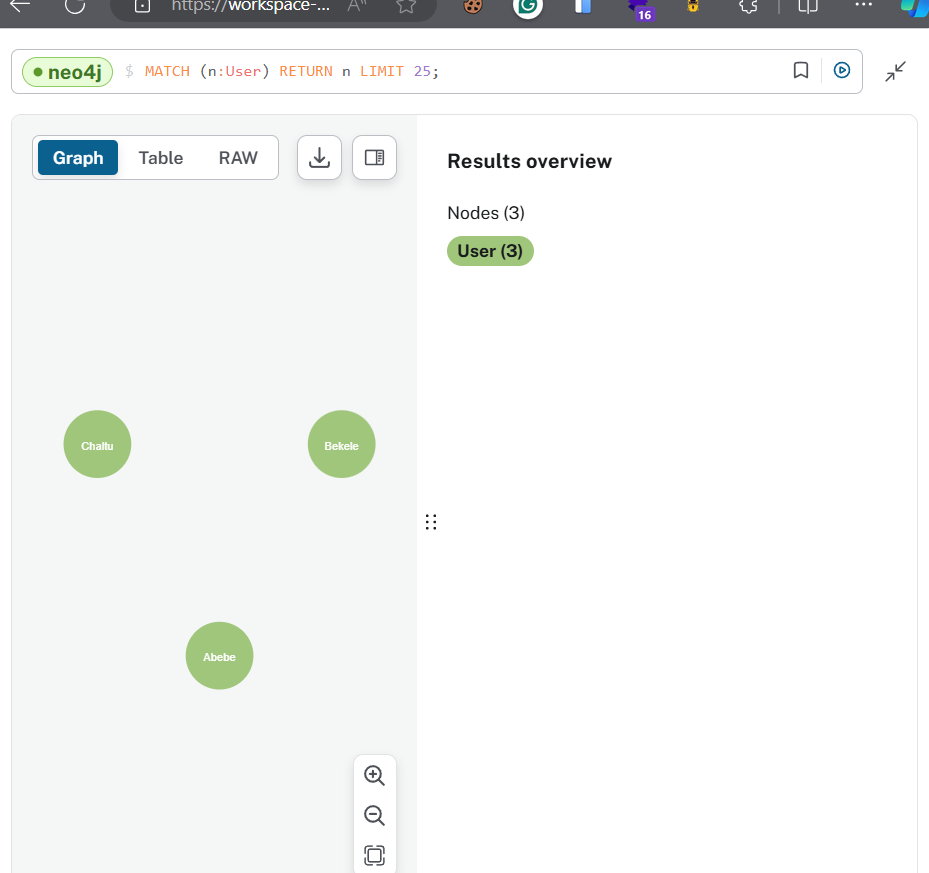


In [9]:
app.update_user_info("1", {"age": 26, "location": "Hawassa"})

C:\Users\Abdulmunim\AppData\Local\Temp\ipykernel_9404\3390639188.py:22: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(self._update_user_node, user_id, updated_info)


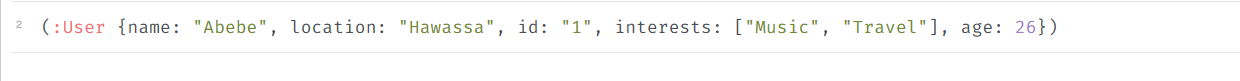


In [10]:
app.send_friend_request("1", "2")
app.send_friend_request("3", "1")
app.accept_friend_request("2", "1")
app.accept_friend_request("1", "3")

C:\Users\Abdulmunim\AppData\Local\Temp\ipykernel_9404\3390639188.py:35: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(self._create_friend_request, sender_id, receiver_id)
C:\Users\Abdulmunim\AppData\Local\Temp\ipykernel_9404\3390639188.py:48: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(self._accept_friend_request, sender_id, receiver_id)


In [11]:
app.create_post("1", "Hello, world!", "2024-06-05T12:00:00")
app.create_post("2", "Enjoying the sunny weather!", "2024-06-05T14:00:00")
app.create_post("3", "Reading a great book!", "2024-06-05T16:00:00")

C:\Users\Abdulmunim\AppData\Local\Temp\ipykernel_9404\3390639188.py:92: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(self._create_post_node, user_id, content, timestamp)


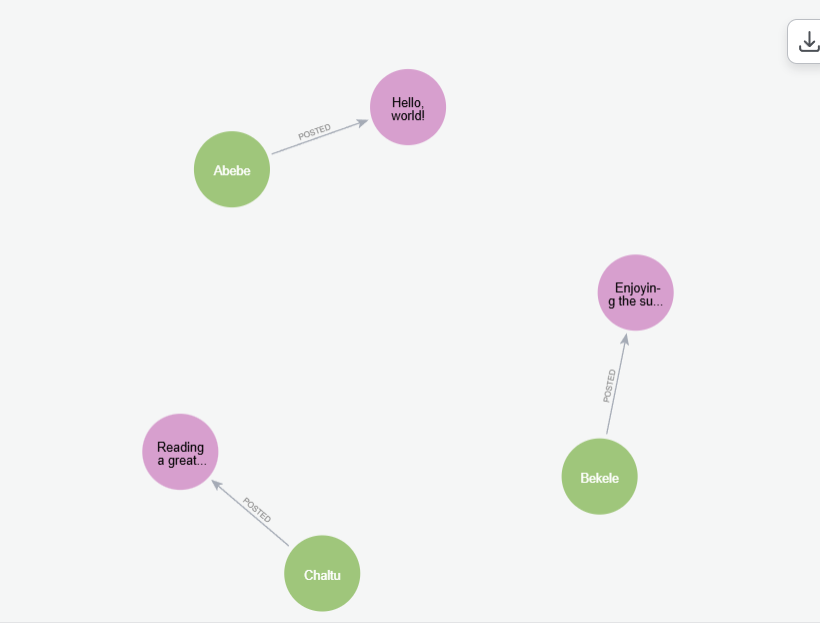


In [12]:
app.like_post("1", "1")
app.like_post("2", "2")
app.comment_on_post("3", "1", "Nice post!")
app.comment_on_post("1", "3", "What's the book?")

C:\Users\Abdulmunim\AppData\Local\Temp\ipykernel_9404\3390639188.py:104: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(self._create_like_relationship, user_id, post_id)
C:\Users\Abdulmunim\AppData\Local\Temp\ipykernel_9404\3390639188.py:116: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(self._create_comment_relationship, user_id, post_id, comment_text)


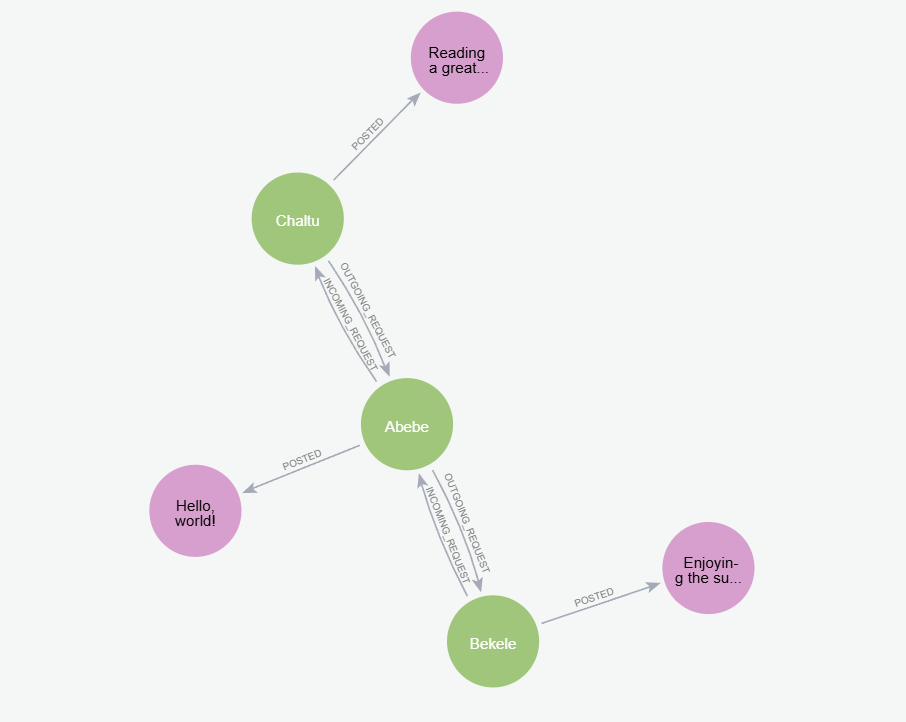


In [13]:
app.join_group("1", "MusicLovers")
app.join_group("2", "Foodies")
app.join_group("3", "BookClub")

C:\Users\Abdulmunim\AppData\Local\Temp\ipykernel_9404\3390639188.py:128: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(self._create_join_relationship, user_id, group_id)


In [18]:
users = app.search_users("Abebe")
print("Search results for 'Abebe':", users)


C:\Users\Abdulmunim\AppData\Local\Temp\ipykernel_9404\3390639188.py:154: DeprecationWarning: read_transaction has been renamed to execute_read
  return session.read_transaction(self._search_for_users, search_name)


Search results for 'Abebe': [<Node element_id='4:f93e37df-9f14-493d-9f83-744a5b53b1d2:9' labels=frozenset({'User'}) properties={'name': 'Abebe', 'location': 'Hawassa', 'id': '1', 'interests': ['Music', 'Travel'], 'age': 26}>]
